In [0]:
from  keras.applications import VGG16
from keras import backend as K
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

layer_name='block3_conv1'

In [0]:
def deprocess_image(x):
  
  #평균이 0 표준편차가 0.1이 되도록 정규화 
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  
  x += 0.5
  x = np.clip(x, 0, 1)

  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])

  grads = K.gradients(loss, model.input)[0]

  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

  iterate = K.function([model.input], [loss, grads])

  # 잡음이 섞인 회색 이미지 
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128

  step = 1.
  for i in range(40):
    loss_val, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

  img = input_img_data[0]
  return deprocess_image(img)

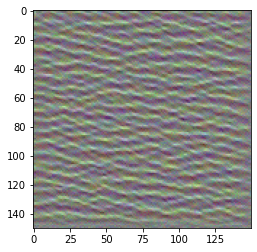

In [19]:
import matplotlib.pyplot as plt

plt.imshow(generate_pattern(layer_name, 1))

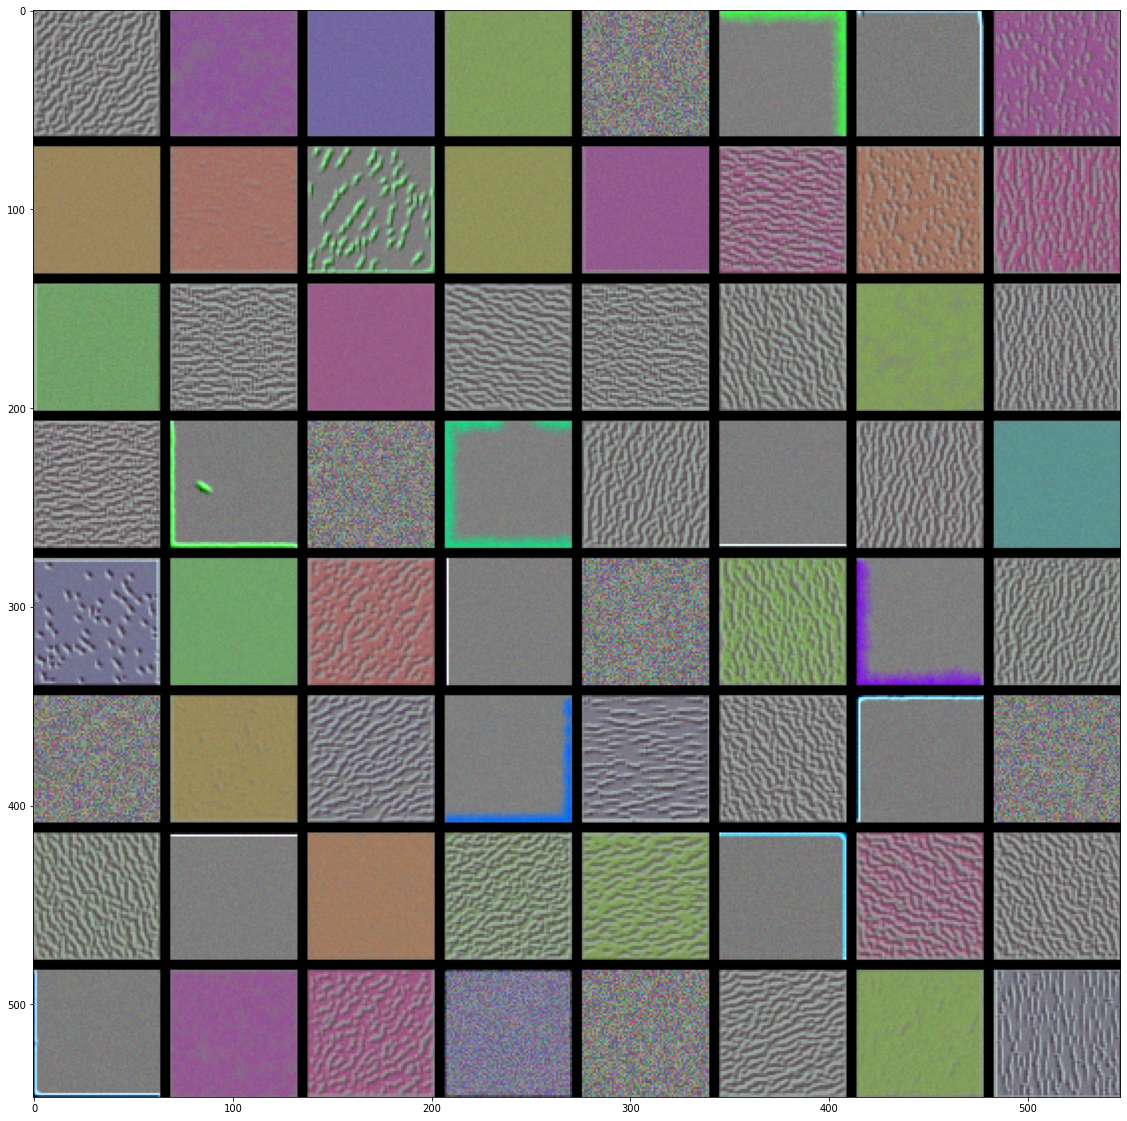

In [33]:
# 그리드를 표현 해야함 
size = 64
margin = 5


display_grid = np.zeros((size * 8 + margin * 7,  size * 8 + margin * 7, 3), dtype='uint8')

# 각각의 활성화를 하나의 큰 그리드에 그린다
for i in range(8):
  for j in range(8):
    channel_image = generate_pattern(layer_name, i+(j*8) ,size=size)

    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size

    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size

    display_grid[horizontal_start : horizontal_end, vertical_start : vertical_end, :] = channel_image



#plt.title(layer_name)
plt.figure(figsize=(20, 20))
plt.imshow(display_grid)